<Figure size 1000x1000 with 0 Axes>

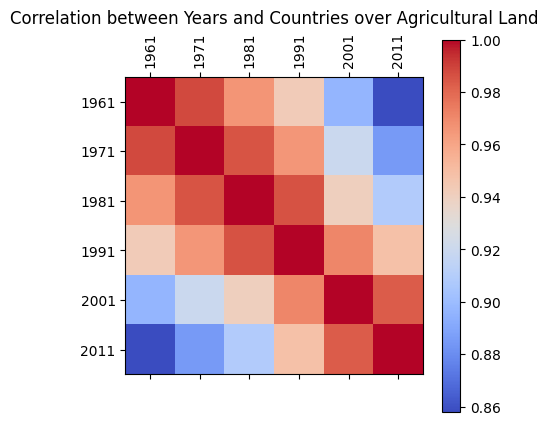

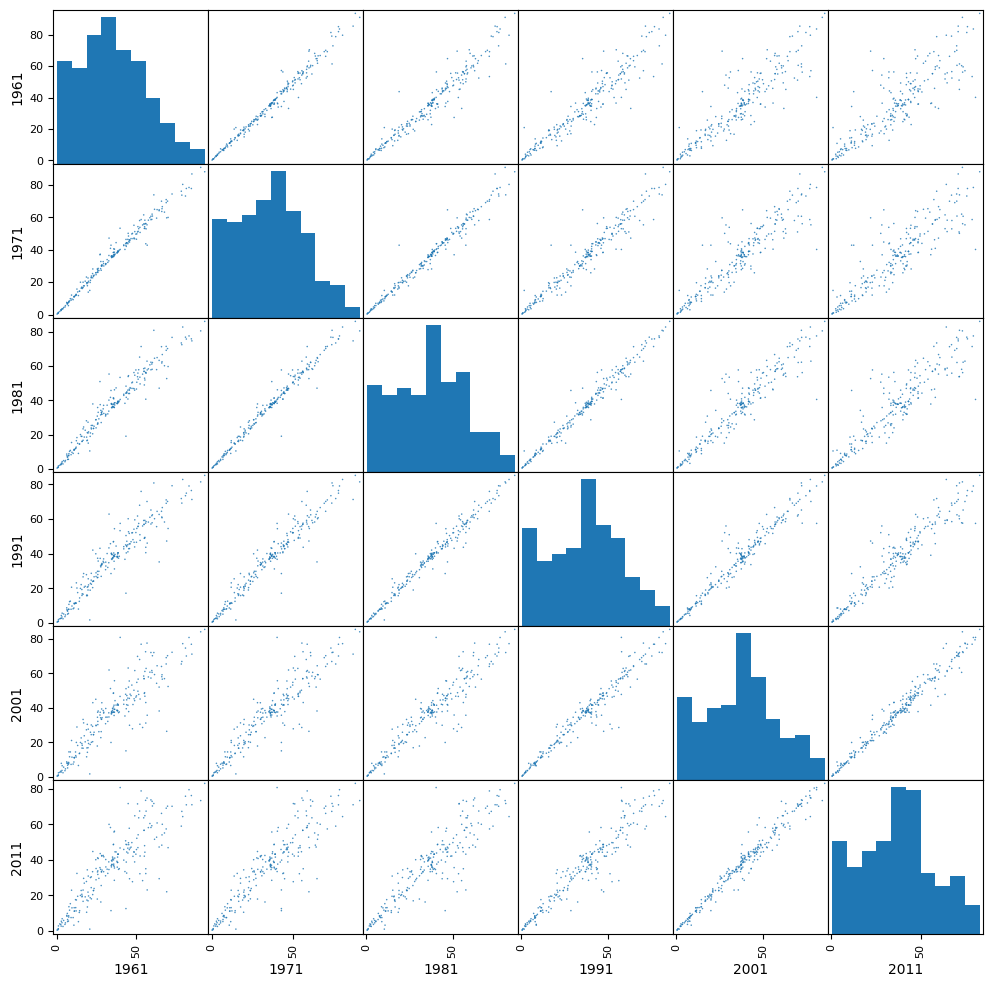

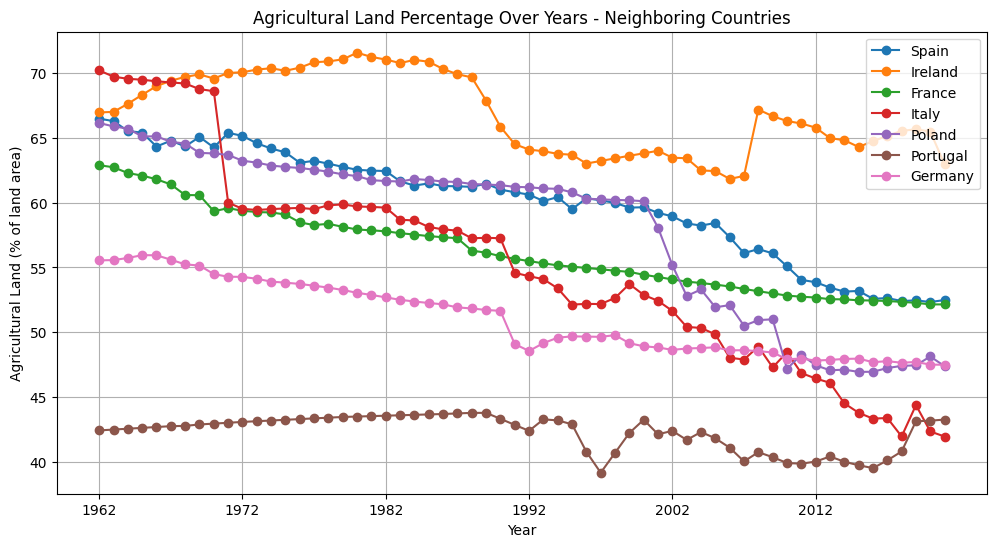

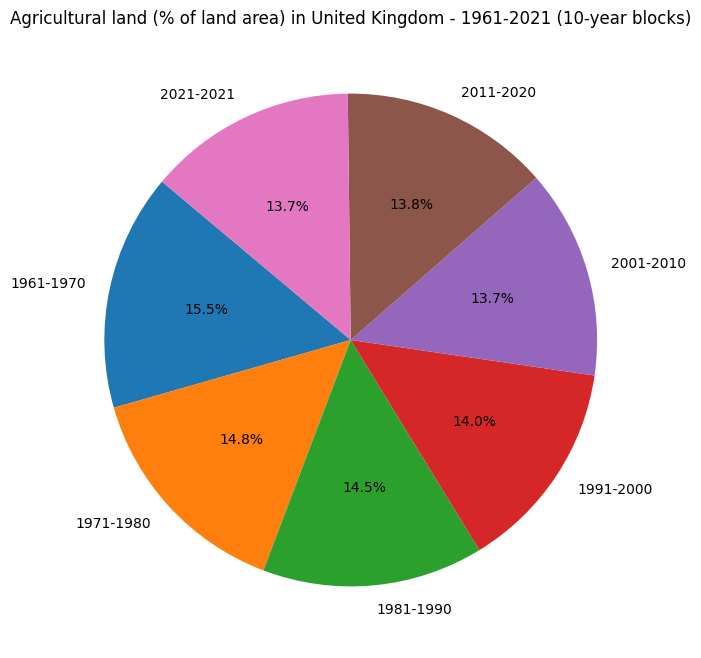

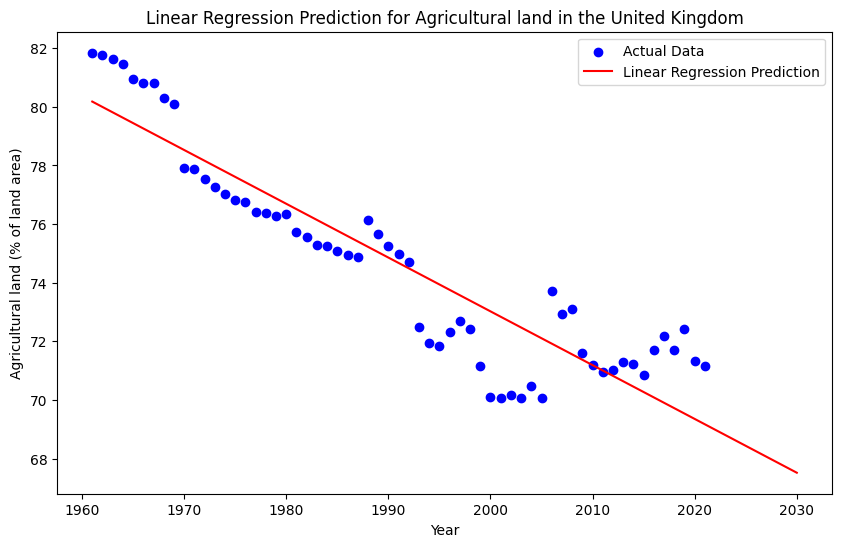

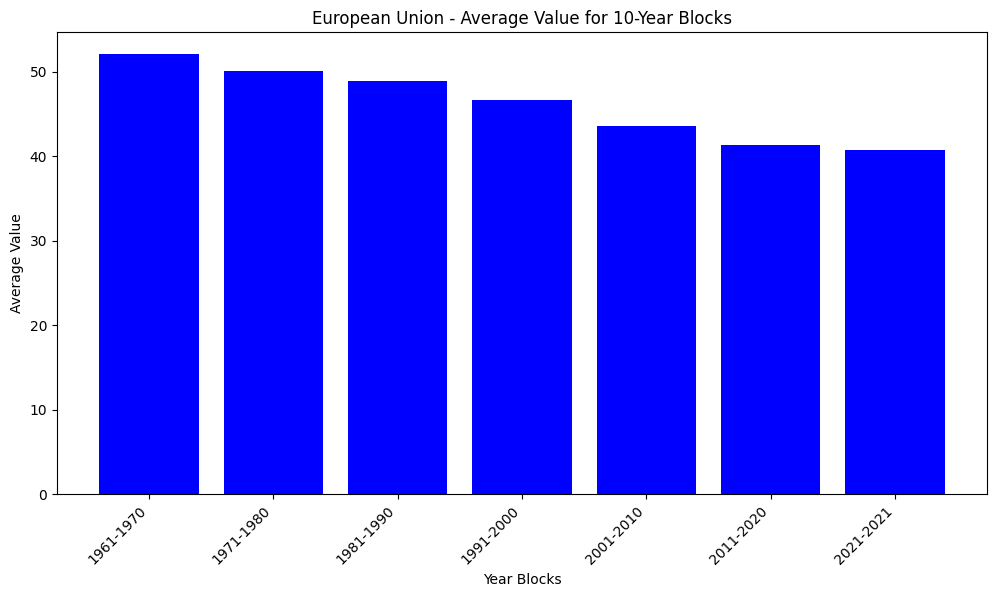

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
import sklearn.metrics as skmet
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assuming you have already read the CSV file into the DataFrame
file_path = 'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_6299921.csv'
df = pd.read_csv(file_path, skiprows=4)

# Define the columns to be deleted
columns_to_delete = ['Unnamed: 67', '1960', '2022']

# Use try-except to handle potential errors when deleting columns
try:
    # Drop the specified columns
    df = df.drop(columns=columns_to_delete)
except KeyError as e:
    # Handle the case where a specified column does not exist
    print(f"Error: {e} not found in the DataFrame.")
def reading_data(filepath):
    df = pd.read_csv(filepath, skiprows=4)
    df = df.set_index('Country Name', drop=True)
    df = df.loc[:, '1961':'2021']  # Adjust the years based on your dataset
    return df

def transpose(df):
    df_tr = df.transpose()
    return df_tr

def correlation_and_scattermatrix(df):
    corr = df.corr()
    plt.figure(figsize=(10, 10))
    plt.matshow(corr, cmap='coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlation between Years and Countries over Agricultural Land')
    plt.colorbar()
    plt.show()

    pd.plotting.scatter_matrix(df, figsize=(12, 12), s=5, alpha=0.8)
    plt.show()

def cluster_number(df, df_normalised):
    clusters = []
    scores = []

    for ncluster in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=ncluster)
        kmeans.fit(df_normalised)
        lab = kmeans.labels_
        scores.append(skmet.silhouette_score(df, lab))

    best_ncluster = np.argmax(scores) + 2  # Add 2 as range starts from 2
    print('Best number of clusters:', best_ncluster)
    return best_ncluster

def clusters_and_centers(df, ncluster, y1, y2):
    kmeans = cluster.KMeans(n_clusters=ncluster)
    kmeans.fit(df)
    lab = kmeans.labels_
    df['labels'] = lab
    centres = kmeans.cluster_centers_

    plt.figure(figsize=(8.0, 8.0))
    cm = plt.cm.get_cmap('tab10')
    sc = plt.scatter(df[y1], df[y2], 10, lab, marker="o", cmap=cm)
    plt.scatter(centres[:, 0], centres[:, 1], 45, "k", marker="d")
    plt.xlabel(f"Agricultural Land (% of land area) - {y1}")
    plt.ylabel(f"Agricultural Land (% of land area) - {y2}")
    plt.legend(*sc.legend_elements(), title='Clusters')
    plt.title('Clusters of Agricultural Land (% of land area)')
    plt.show()

    return df, centres

# Modify the file path based on your dataset
file_path = 'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_6299921.csv'
agri_land = reading_data(file_path)
agri_land_tr = transpose(agri_land)

# Selecting years for analysis
agri_land_analysis = agri_land[["1961", '1971', "1981", '1991', "2001", '2011']]
correlation_and_scattermatrix(agri_land_analysis)

# Selecting countries
selected_countries = ['Spain', 'Ireland', 'France', 'Italy', 'Poland', 'Portugal', 'Germany']

# Extracting data for the selected countries
countries_data = df[df['Country Name'].isin(selected_countries)].set_index('Country Name').iloc[:, 4:]

plt.figure(figsize=(12, 6))
for country in selected_countries:
    plt.plot(countries_data.columns, countries_data.loc[country].values, marker='o', linestyle='-', label=country)

plt.title(f'Agricultural Land Percentage Over Years - Neighboring Countries')
plt.xlabel('Year')
plt.ylabel('Agricultural Land (% of land area)')
plt.legend()
plt.grid(True)

# Setting x-axis ticks with a 10-year gap
plt.xticks(countries_data.columns[::10])

plt.show()

# Extracting data for the 'Agricultural land (% of land area)' indicator in the United Kingdom
uk_data = df[df['Country Name'] == 'United Kingdom']

# Extracting available years
available_years = uk_data.columns[4:]

# Create 10-year blocks and calculate the average for each block
blocks = [available_years[i:i+10] for i in range(0, len(available_years), 10)]
average_values = [uk_data[block].mean(axis=1) for block in blocks]

# Combine all average values into a single list
combined_values = [value.mean() for value in average_values]

# Create labels for each 10-year block
block_labels = [f'{block[0]}-{block[-1]}' for block in blocks]

# Plot a single pie chart
plt.figure(figsize=(8, 8))
plt.pie(combined_values, labels=block_labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Agricultural land (% of land area) in United Kingdom - 1961-2021 (10-year blocks)')
plt.show()

# Transpose the data for time series analysis
uk_data = uk_data.transpose()[4:]
uk_data.columns = ['Agricultural land (% of land area)']

# Reset index to have 'Year' as a separate column
uk_data.reset_index(inplace=True)
uk_data.columns = ['Year', 'Agricultural land (% of land area)']

# Convert 'Year' to numeric
uk_data['Year'] = pd.to_numeric(uk_data['Year'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    uk_data['Year'].values.reshape(-1, 1),
    uk_data['Agricultural land (% of land area)'].values,
    test_size=0.2,
    random_state=42
)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for future years
future_years = np.arange(2022, 2031).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(uk_data['Year'], uk_data['Agricultural land (% of land area)'], color='blue', label='Actual Data')
plt.plot(np.concatenate([uk_data['Year'], future_years.flatten()]),
         np.concatenate([model.predict(uk_data['Year'].values.reshape(-1, 1)),
                         future_predictions]),
         color='red', label='Linear Regression Prediction')
plt.xlabel('Year')
plt.ylabel('Agricultural land (% of land area)')
plt.title('Linear Regression Prediction for Agricultural land in the United Kingdom')
plt.legend()
plt.show()


selected_country = 'European Union'
country_data = df[df['Country Name'] == selected_country]

# Extracting available years
available_years = country_data.columns[4:]

# Create 10-year blocks and calculate the average for each block
blocks = [available_years[i:i+10] for i in range(0, len(available_years), 10)]
average_values = [country_data[block].mean(axis=1) for block in blocks]

# Combine all average values into a single list
combined_values = [value.mean() for value in average_values]

# Create labels for each 10-year block
block_labels = [f'{block[0]}-{block[-1]}' for block in blocks]

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(block_labels, combined_values, color='blue')
plt.xlabel('Year Blocks')
plt.ylabel('Average Value')
plt.title(f'{selected_country} - Average Value for 10-Year Blocks')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()